In [ ]:
from collections import Counter
from pathlib import Path

import cv2
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from PIL import Image
from scipy.special import expit as sigmoid
from tqdm import tqdm

In [87]:
DATA_PATH = "/home/taheera.ahmed/data/nedbygging/"
data_path = Path(DATA_PATH)

CLASS_LABELS = {
    "unclassified": 0,  # Uklassifisert
    "settlement_transport": 1,  # Bebyggelse/samferdsel
    "cultivated_land": 2,  # Dyrket mark
    "grassland": 3,  # Grasmark
    "forest": 4,  # Skog
    "heath_and_open_vegetation": 5,  # Hei og åpen vegetasjon
    "sparse_vegetation_land": 6,  # Lite vegetert mark
    "wetland": 7,  # Våtmark
    "water": 8,  # Vann
}
CLASS_NAMES = {v: k for k, v in CLASS_LABELS.items()}
class_labels = CLASS_LABELS.keys()


def get_color_map_and_legend():
    # Define colors corresponding to each class in order
    class_colors = [
        "black",
        "red",
        "yellow",
        "lime",
        "green",
        "purple",
        "cyan",
        "magenta",
        "blue",
    ]
    # Create legend elements with the corresponding colors
    legend_elements = [
        Patch(facecolor=class_colors[i], edgecolor="black", label=label)
        for i, label in enumerate(CLASS_LABELS.keys())
    ]
    return class_colors, legend_elements


# Retrieve colors and legend elements
class_colors, legend_elements = get_color_map_and_legend()

In [88]:
train_path_imgs = data_path / "new_train_val_scene" / "train"
train_path_masks = data_path / "new_train_val_truth" / "train"
val_path_imgs = data_path / "new_train_val_scene" / "val"
val_path_masks = data_path / "new_train_val_truth" / "val"

In [89]:
train_imgs = list((train_path_imgs).glob("*.tif"))
train_masks = list((train_path_masks).glob("*.tif"))

val_imgs = list((val_path_imgs).glob("*.tif"))
val_masks = list((val_path_masks).glob("*.tif"))

In [90]:
train_imgs.sort()
train_masks.sort()

val_imgs.sort()
val_masks.sort()

# Look at masks


In [91]:
all_masks = train_masks + val_masks
class_distribution = Counter()
for mask_path in tqdm(all_masks):
    # Load the mask
    mask = rxr.open_rasterio(mask_path)

    # Convert to numpy array and flatten to 1D
    mask_array = mask.values.flatten()

    # Count occurrences of each class value
    counts = Counter(mask_array)

    # Add to total distribution
    class_distribution.update(counts)


100%|██████████| 10/10 [00:31<00:00,  3.19s/it]


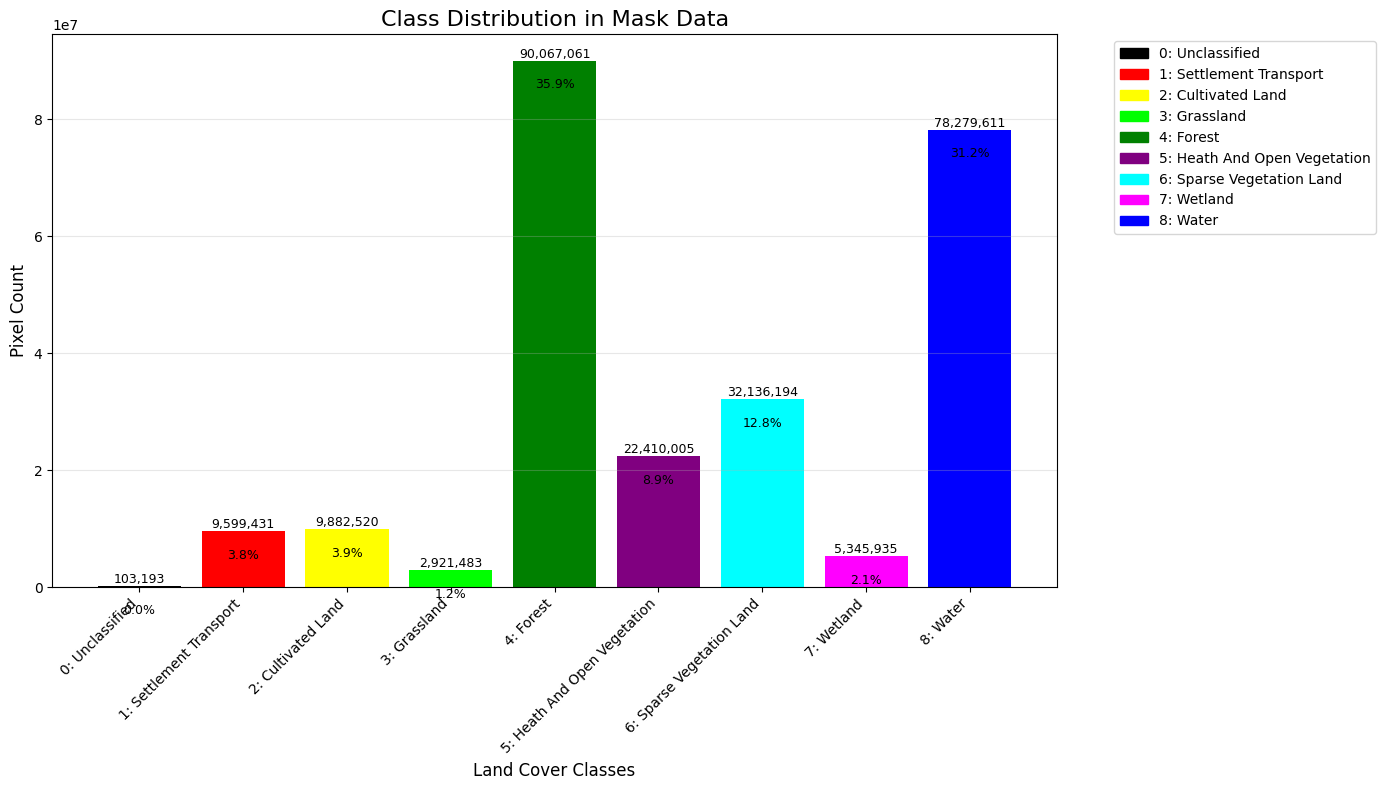


Class distribution summary:
Class 0 (Unclassified): 103,193 pixels (0.04%)
Class 1 (Settlement Transport): 9,599,431 pixels (3.83%)
Class 2 (Cultivated Land): 9,882,520 pixels (3.94%)
Class 3 (Grassland): 2,921,483 pixels (1.17%)
Class 4 (Forest): 90,067,061 pixels (35.92%)
Class 5 (Heath And Open Vegetation): 22,410,005 pixels (8.94%)
Class 6 (Sparse Vegetation Land): 32,136,194 pixels (12.82%)
Class 7 (Wetland): 5,345,935 pixels (2.13%)
Class 8 (Water): 78,279,611 pixels (31.22%)

Class imbalance ratio (most common / least common): 872.80


In [92]:
if -9999 in class_distribution:
    del class_distribution[-9999]
if np.nan in class_distribution:
    del class_distribution[np.nan]

# Sort by class ID
class_ids = sorted(class_distribution.keys())
pixel_counts = [class_distribution[id] for id in class_ids]

# Create a bar plot with custom colors
plt.figure(figsize=(14, 8))
bars = plt.bar(class_ids, pixel_counts, color=[class_colors[int(i)] for i in class_ids])

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:,}",
        ha="center",
        va="bottom",
        rotation=0,
        fontsize=9,
    )

# Calculate total pixels and percentages
total_pixels = sum(pixel_counts)
percentages = [(count / total_pixels) * 100 for count in pixel_counts]

# Add percentage labels
for i, (count, percentage) in enumerate(zip(pixel_counts, percentages, strict=False)):
    plt.annotate(
        f"{percentage:.1f}%",
        xy=(class_ids[i], count),
        xytext=(0, -20),
        textcoords="offset points",
        ha="center",
        fontsize=9,
    )

# Create readable x-tick labels with both id, name and color
x_labels = []
for class_id in class_ids:
    class_name = CLASS_NAMES.get(int(class_id), "Unknown")
    # Make the class name more readable by replacing underscores with spaces and capitalizing
    pretty_name = class_name.replace("_", " ").title()
    x_labels.append(f"{int(class_id)}: {pretty_name}")

# Set x-axis tick labels
plt.xticks(class_ids, x_labels, rotation=45, ha="right")

# Create legend with color patches
legend_patches = []
for i, color in enumerate(class_colors):
    if i in CLASS_NAMES:  # Only add classes that exist
        class_name = CLASS_NAMES[i].replace("_", " ").title()
        legend_patches.append(mpatches.Patch(color=color, label=f"{i}: {class_name}"))

plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc="upper left")

# Add plot details
plt.title("Class Distribution in Mask Data", fontsize=16)
plt.xlabel("Land Cover Classes", fontsize=12)
plt.ylabel("Pixel Count", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

# Save and show the plot
plt.savefig("class_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# Print summary statistics
print("\nClass distribution summary:")
for class_id, count in zip(class_ids, pixel_counts, strict=False):
    percentage = (count / total_pixels) * 100
    class_name = CLASS_NAMES.get(int(class_id), "Unknown").replace("_", " ").title()
    print(f"Class {int(class_id)} ({class_name}): {count:,} pixels ({percentage:.2f}%)")

# Calculate class imbalance ratio (most common / least common)
max_count = max(pixel_counts)
min_count = min(pixel_counts)
imbalance_ratio = max_count / min_count if min_count > 0 else float("inf")
print(f"\nClass imbalance ratio (most common / least common): {imbalance_ratio:.2f}")

In [93]:
print("\nPer-image class distribution summary:")
for idx, mask_path in enumerate(all_masks):
    print(f"\nImage {idx + 1}: {mask_path.absolute()}")

    # Load and process mask again for statistics
    mask = rxr.open_rasterio(mask_path)
    mask_array = mask.values.flatten()
    counts = Counter(mask_array)

    # Remove no-data values
    if -9999 in counts:
        del counts[-9999]
    if np.nan in counts:
        del counts[np.nan]

    # Calculate total
    total = sum(counts.values())

    # Print stats for each class
    for class_id in range(9):
        count = counts.get(class_id, 0)
        percentage = (count / total) * 100 if total > 0 else 0
        class_name = CLASS_NAMES.get(class_id, "Unknown").replace("_", " ").title()
        print(
            f"  Class {class_id} ({class_name}): {count:,} pixels ({percentage:.2f}%)"
        )


Per-image class distribution summary:

Image 1: /home/taheera.ahmed/data/nedbygging/new_train_val_truth/train/truth_2019_0.tif
  Class 0 (Unclassified): 411 pixels (0.00%)
  Class 1 (Settlement Transport): 161,298 pixels (0.64%)
  Class 2 (Cultivated Land): 204,617 pixels (0.82%)
  Class 3 (Grassland): 79,673 pixels (0.32%)
  Class 4 (Forest): 4,306,120 pixels (17.17%)
  Class 5 (Heath And Open Vegetation): 3,505,482 pixels (13.97%)
  Class 6 (Sparse Vegetation Land): 3,473,682 pixels (13.85%)
  Class 7 (Wetland): 873,400 pixels (3.48%)
  Class 8 (Water): 12,480,359 pixels (49.75%)

Image 2: /home/taheera.ahmed/data/nedbygging/new_train_val_truth/train/truth_2019_1.tif
  Class 0 (Unclassified): 31 pixels (0.00%)
  Class 1 (Settlement Transport): 1,798,411 pixels (7.17%)
  Class 2 (Cultivated Land): 552,956 pixels (2.21%)
  Class 3 (Grassland): 449,272 pixels (1.79%)
  Class 4 (Forest): 8,691,250 pixels (34.67%)
  Class 5 (Heath And Open Vegetation): 3,117,733 pixels (12.44%)
  Class 6

## Choose one image


In [94]:
idx = 0
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])
print(train_imgs[idx])
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

/home/taheera.ahmed/data/nedbygging/new_train_val_scene/train/scene_2019_0.tif
Image shape: (30, 5014, 5003)
Mask shape: (1, 5014, 5003)


In [95]:
month_idx = 4  # Change this based on the desired month (0-4)
band_offset = month_idx * 6  # Since each month has 6 bands

blue_band = band_offset + 0
green_band = band_offset + 1
red_band = band_offset + 2


[np.int32(7810000), np.int32(4560000), np.int32(2630000), np.int32(2205000), np.int32(1320000), np.int32(150000)]
[np.int32(124635000), np.int32(123350000), np.int32(133265000), np.int32(131605000), np.int32(114600000), np.int32(50060000)]


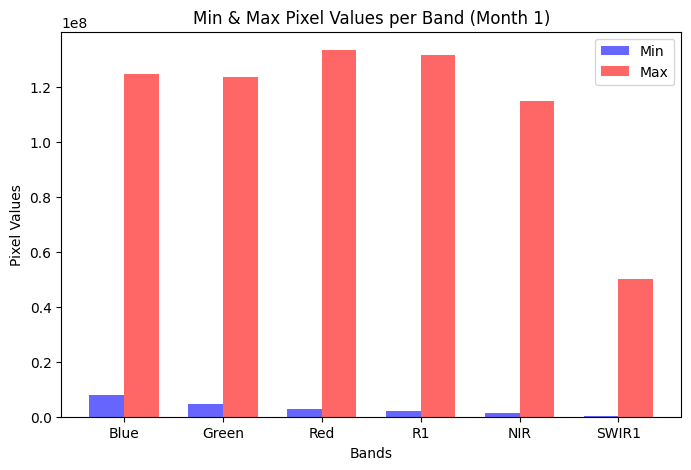

In [96]:
def plot_band_min_max(img, month_idx=0):
    """Plots the min and max values of all bands for a selected month.

    Args:
        img (xarray.DataArray): Raster image data.
        month_idx (int): Index of the desired month (0-4).
    """
    band_offset = month_idx * 6  # Since each month has 6 bands
    band_names = ["Blue", "Green", "Red", "R1", "NIR", "SWIR1"]

    min_vals = []
    max_vals = []

    for i in range(6):
        band_idx = band_offset + i
        min_vals.append(img.data[band_idx].min())
        max_vals.append(img.data[band_idx].max())

    print(min_vals)
    print(max_vals)
    # Plotting min/max values for each band
    x = np.arange(len(band_names))
    width = 0.35  # Bar width

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.bar(x - width / 2, min_vals, width, label="Min", color="blue", alpha=0.6)
    ax.bar(x + width / 2, max_vals, width, label="Max", color="red", alpha=0.6)

    ax.set_xlabel("Bands")
    ax.set_ylabel("Pixel Values")
    ax.set_title(f"Min & Max Pixel Values per Band (Month {month_idx + 1})")
    ax.set_xticks(x)
    ax.set_xticklabels(band_names)
    ax.legend()

    plt.show()


plot_band_min_max(img, month_idx=0)

In [97]:
rgb_img = img[[red_band, green_band, blue_band]].data

## just normalized


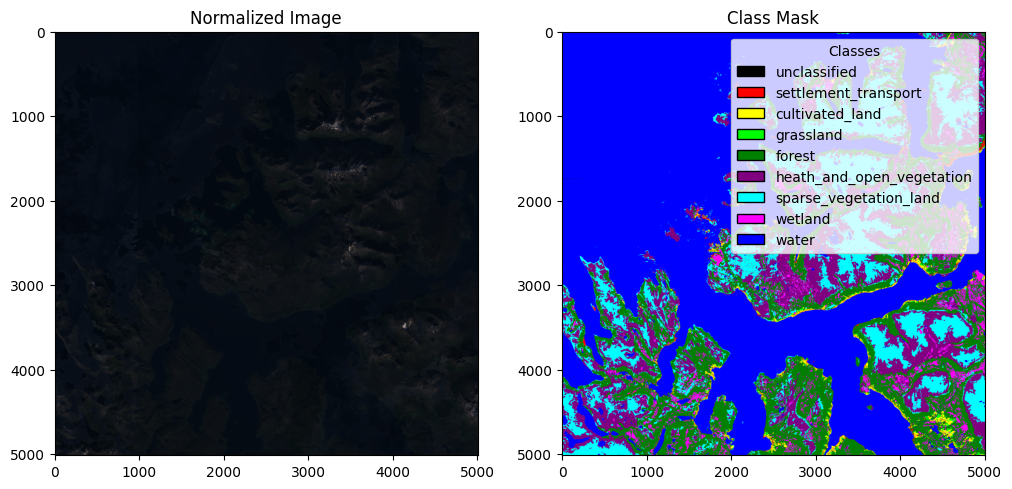

In [98]:
def normalize_image(image):
    """Normalize image using min-max scaling."""
    return (image - image.min()) / (image.max() - image.min())


norm_image = normalize_image(rgb_img)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Display the corrected image
axs[0].imshow(norm_image.transpose(1, 2, 0))
axs[0].set_title("Normalized Image")

# Plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")
plt.show()


## Precentile clipping


Okay this is better


The pixel values are extremely high (millions to hundreds of millions), which explains why your image appears too dark when divided by 2000 or even normalized to [0,1].


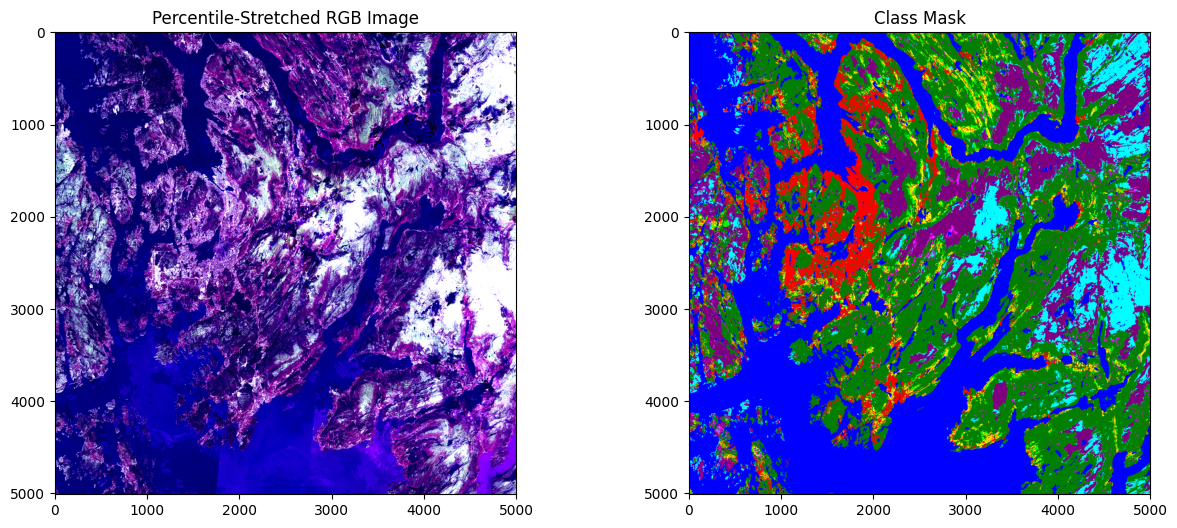

In [ ]:
def normalize_percentile(img_array, percentiles=(30, 90)):
    """Normalize image using percentile clipping to enhance contrast."""
    min_val, max_val = np.percentile(img_array, percentiles)
    return np.clip((img_array - min_val) / (max_val - min_val), 0, 1)


_, axs = plt.subplots(1, 2, figsize=(15, 6))
rgb_img = img.data[[red_band, green_band, blue_band]].transpose((1, 2, 0))
rgb_norm_percentile = normalize_percentile(rgb_img)  # Apply normalization

# Display the corrected image
axs[0].imshow(rgb_norm_percentile)
axs[0].set_title("Percentile-Stretched RGB Image")

# Plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

# Create a legend for the mask
legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label)
    for color, label in zip(class_colors, class_labels, strict=False)
]

# axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")
plt.show()

## Histogram equalization


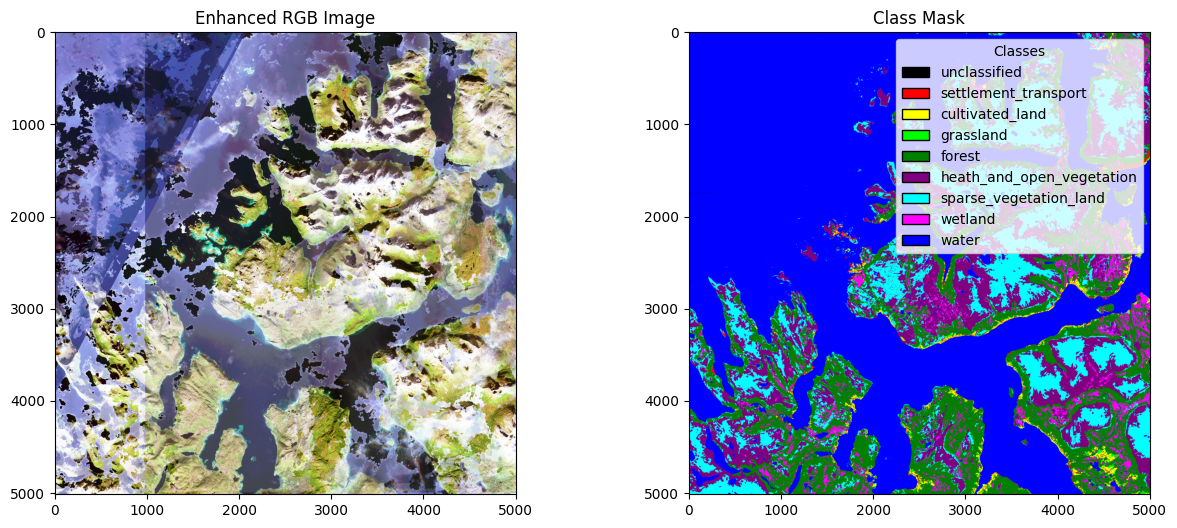

In [100]:
_, axs = plt.subplots(1, 2, figsize=(15, 6))


def hist_equalization(image):
    """Apply histogram equalization on an image."""
    image = (image * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
    for i in range(3):  # Apply to each channel separately
        image[..., i] = cv2.equalizeHist(image[..., i])
    return image / 255.0  # Scale back to [0,1]


# rgb_norm = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
rgb_norm_percentile = normalize_image(rgb_img)  # Apply normalization
rgb_hist = hist_equalization(rgb_norm_percentile)
axs[0].imshow(rgb_hist)
axs[0].set_title("Enhanced RGB Image")


# Plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

# Create a legend for the mask
legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label)
    for color, label in zip(class_colors, class_labels, strict=False)
]

axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")

plt.show()


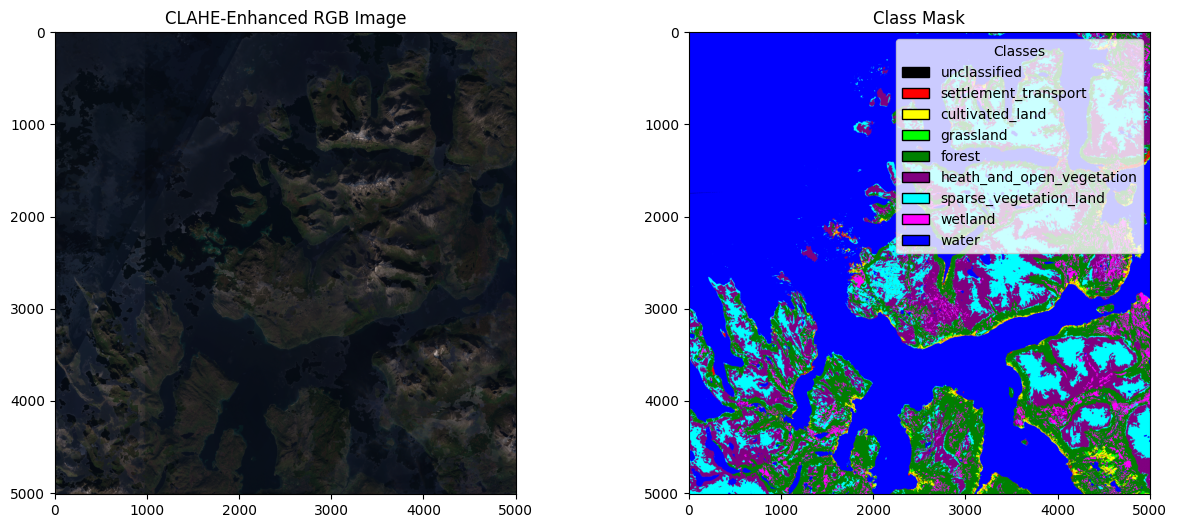

In [101]:
def adaptive_histogram_equalization(image):
    """Apply adaptive histogram equalization on each channel separately."""
    image = (image * 255).astype(np.uint8)  # Convert to uint8
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    for i in range(3):  # Apply CLAHE per channel
        image[..., i] = clahe.apply(image[..., i])

    return image / 255.0  # Scale back to [0,1]


_, axs = plt.subplots(1, 2, figsize=(15, 6))
rgb_norm = normalize_image(rgb_img)  # Apply normalization
rgb_adapt = adaptive_histogram_equalization(rgb_norm)
axs[0].imshow(rgb_adapt)
axs[0].set_title("CLAHE-Enhanced RGB Image")

# Plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

# Create a legend for the mask
legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label)
    for color, label in zip(class_colors, class_labels, strict=False)
]

axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")

plt.show()


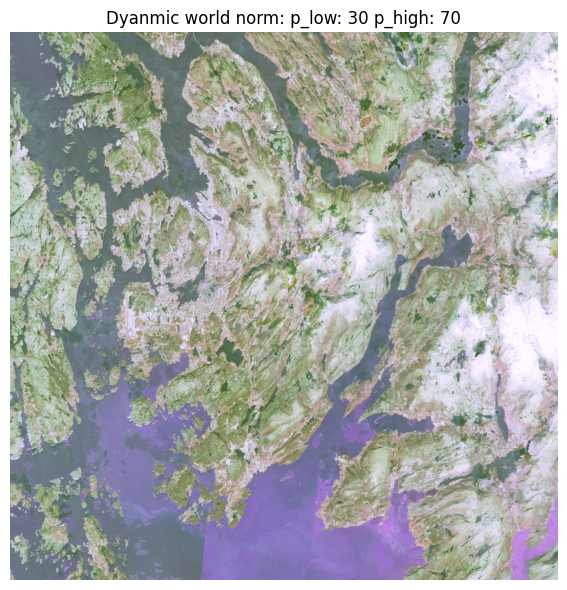

In [119]:
def dynamic_world_normalization(image, p_low=30, p_high=80, log_transform=True):
    """
    Apply the Dynamic World normalization scheme to an image.

    Parameters:
        image (np.ndarray): Input image array (H, W, C).
        p_low (int): Lower percentile for remapping.
        p_high (int): Upper percentile for remapping.
        log_transform (bool): Whether to apply log-transform.

    Returns:
        np.ndarray: Normalized image.
    """
    image = image.astype(np.float32)

    if log_transform:
        image = np.log1p(image)  # log(1 + x) to prevent log(0) issues

    norm_image = np.zeros_like(image)

    for c in range(image.shape[2]):  # Process each channel separately
        low, high = np.percentile(image[..., c], [p_low, p_high])
        if low == high:
            norm_image[..., c] = 0.5  # Assign a neutral value if no variance
        else:
            norm_image[..., c] = sigmoid((image[..., c] - low) / (high - low))

    return norm_image


# Example usage
p_low = 30
p_high = 70

# Create a subplot for each set
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

rgb_norm = dynamic_world_normalization(rgb_img, p_low, p_high)

# Plot the normalized image
ax.imshow(rgb_norm)
ax.set_title(f"Dyanmic world norm: p_low: {p_low} p_high: {p_high}")
ax.axis("off")

plt.tight_layout()
plt.show()

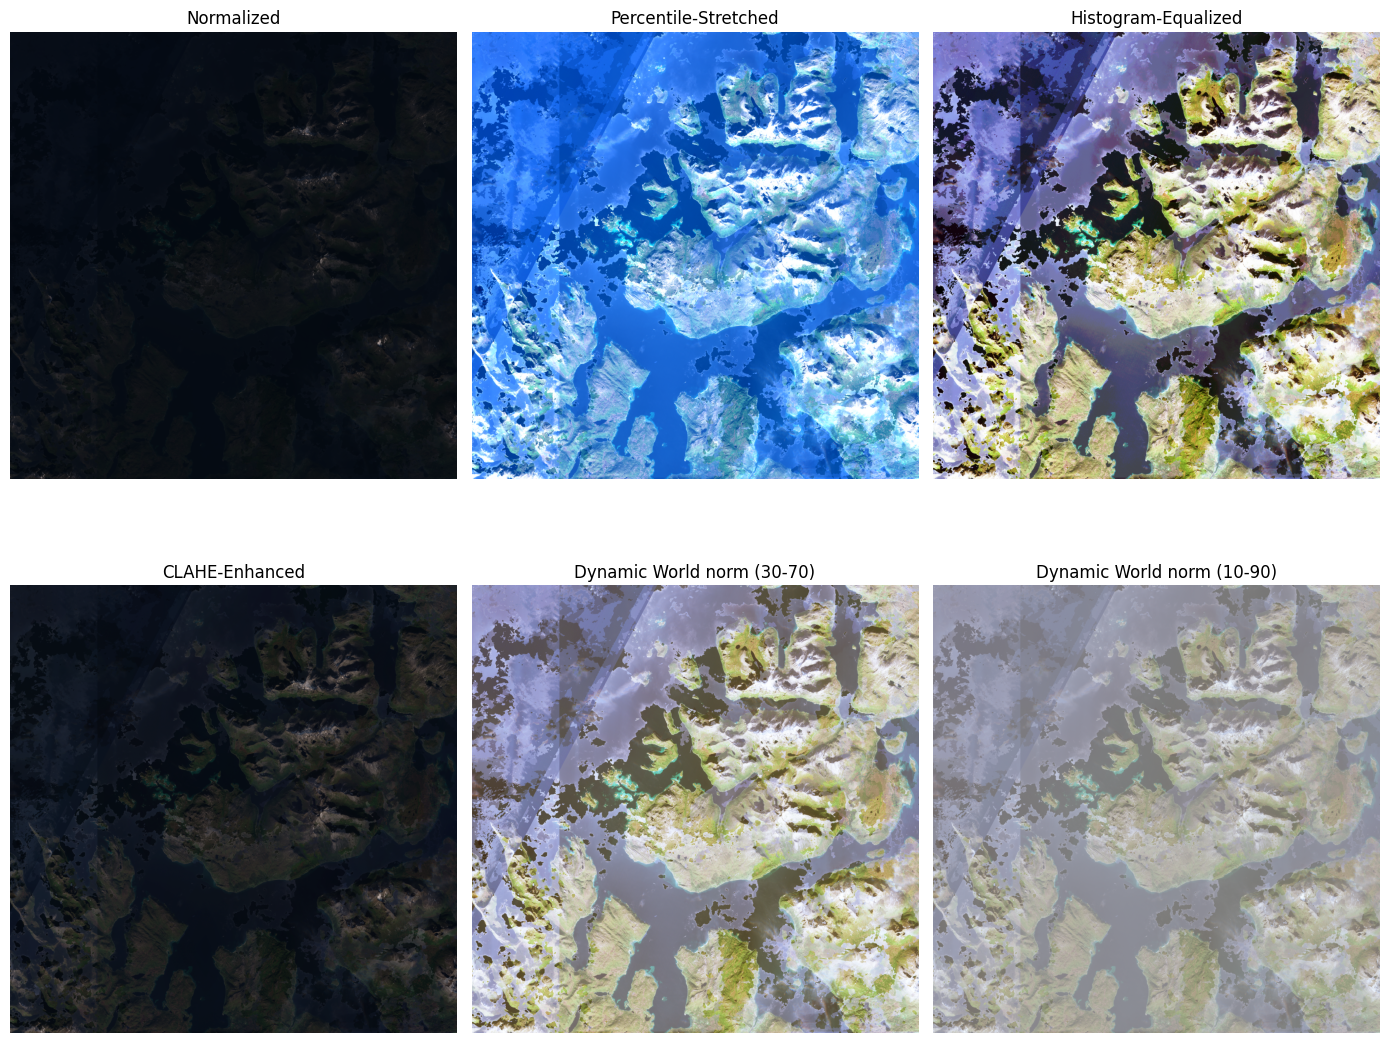

In [103]:
# plot all the different methods in one
_, axs = plt.subplots(2, 3, figsize=(14, 12))

# Original RGB image
axs[0, 0].imshow(normalize_image(rgb_img))
axs[0, 0].set_title("Normalized")
axs[0, 0].axis("off")

axs[0, 1].imshow(normalize_percentile(rgb_img))
axs[0, 1].set_title("Percentile-Stretched")
axs[0, 1].axis("off")

axs[0, 2].imshow(hist_equalization(normalize_image(rgb_img)))
axs[0, 2].set_title("Histogram-Equalized")
axs[0, 2].axis("off")

axs[1, 0].imshow(adaptive_histogram_equalization(normalize_image(rgb_img)))
axs[1, 0].set_title("CLAHE-Enhanced")
axs[1, 0].axis("off")

axs[1, 1].imshow(dynamic_world_normalization(rgb_img, 30, 70))
axs[1, 1].set_title("Dynamic World norm (30-70)")
axs[1, 1].axis("off")

axs[1, 2].imshow(dynamic_world_normalization(rgb_img, 10, 90))
axs[1, 2].set_title("Dynamic World norm (10-90)")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

# Understanding the data

To be honeset I've just tried some random normalization techniques, and they look pretty on this one sample, but that doesn't mean every image will look good. I'll try to explore the data a bit more, and then try to come up with a better normalization technique.


## Land cover exploration


In [122]:
train_imgs = list((train_path_imgs).glob("*.tif"))
train_masks = list((train_path_masks).glob("*.tif"))

val_imgs = list((val_path_imgs).glob("*.tif"))
val_masks = list((val_path_masks).glob("*.tif"))

In [123]:
train_imgs.sort()
train_masks.sort()

val_imgs.sort()
val_masks.sort()

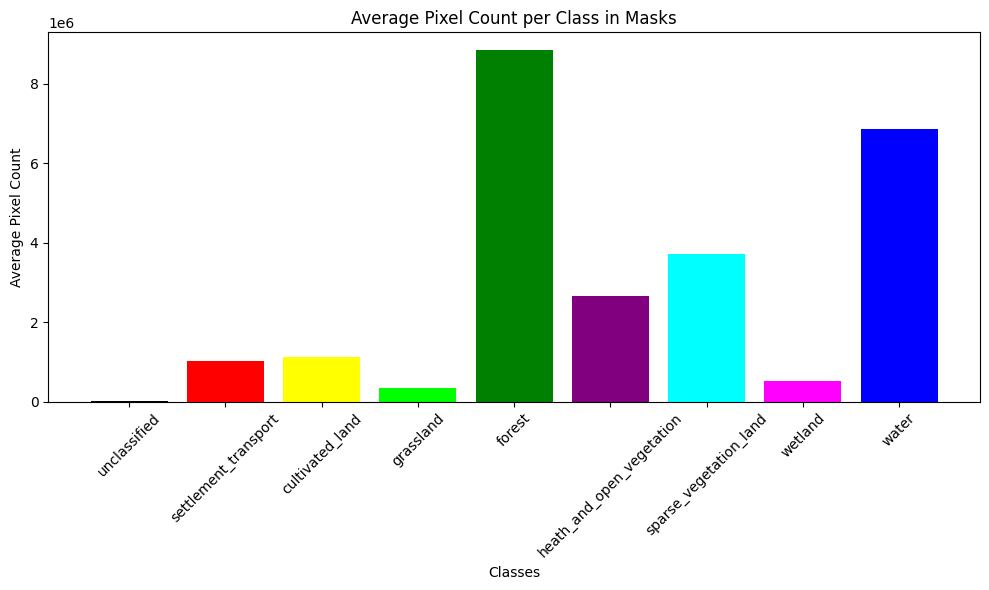

In [124]:
# Initialize a dictionary to accumulate the pixel counts for each class
total_pixel_counts = {class_name: 0 for class_name in CLASS_LABELS}

# Loop through each mask in your training set (or any other set you wish to analyze)
for mask_path in train_masks:
    # Open the mask image and convert it to a numpy array.
    # We assume here that each pixel value corresponds to a class label.
    mask = np.array(Image.open(mask_path))

    # Count pixels for each class in this mask and add them to our total count
    for class_name, label in CLASS_LABELS.items():
        total_pixel_counts[class_name] += np.sum(mask == label)

# Compute the average count per mask for each class
num_masks = len(train_masks)
average_pixels_per_class = {
    class_name: total_pixel_counts[class_name] / num_masks
    for class_name in CLASS_LABELS
}

# Print the results
classes = list(average_pixels_per_class.keys())
avg_counts = [average_pixels_per_class[class_name] for class_name in classes]

plt.figure(figsize=(10, 6))
plt.bar(classes, avg_counts, color=class_colors)
plt.xlabel("Classes")
plt.ylabel("Average Pixel Count")
plt.title("Average Pixel Count per Class in Masks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [125]:
idx = 1
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])
cropped_img = img.isel(x=slice(256, 512), y=slice(256, 512))
cropped_mask = mask.isel(x=slice(256, 512), y=slice(256, 512))

In [108]:
img.shape

(30, 5010, 5004)

In [109]:
cropped_img.shape, cropped_mask.shape

((30, 256, 256), (1, 256, 256))

In [126]:
month_idx = 0  # Change this based on the desired month (0-4)
band_offset = month_idx * 6  # Since each month has 6 bands

blue_band = band_offset + 0
red_band = band_offset + 1
green_band = band_offset + 2

r1_band = band_offset + 3
nir_band = band_offset + 4
swir1_band = band_offset + 5

In [127]:
def extract_patches(img, patch_size=256):
    """
    Extract non-overlapping patches of size patch_size x patch_size from an image.
    """
    img_arr = img.values  # Convert xarray to numpy
    h, w = img_arr.shape[1], img_arr.shape[2]  # Get height & width

    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img_arr[:, i : i + patch_size, j : j + patch_size]
            if patch.shape[1] == patch_size and patch.shape[2] == patch_size:
                patches.append(patch)

    return np.array(patches)  # Shape: (num_patches, C, patch_size, patch_size)


img_patches = extract_patches(img, patch_size=256)
mask_patches = extract_patches(mask, patch_size=256)


In [ ]:
img_patches.shape, mask_patches.shape

((361, 30, 256, 256), (361, 1, 256, 256))

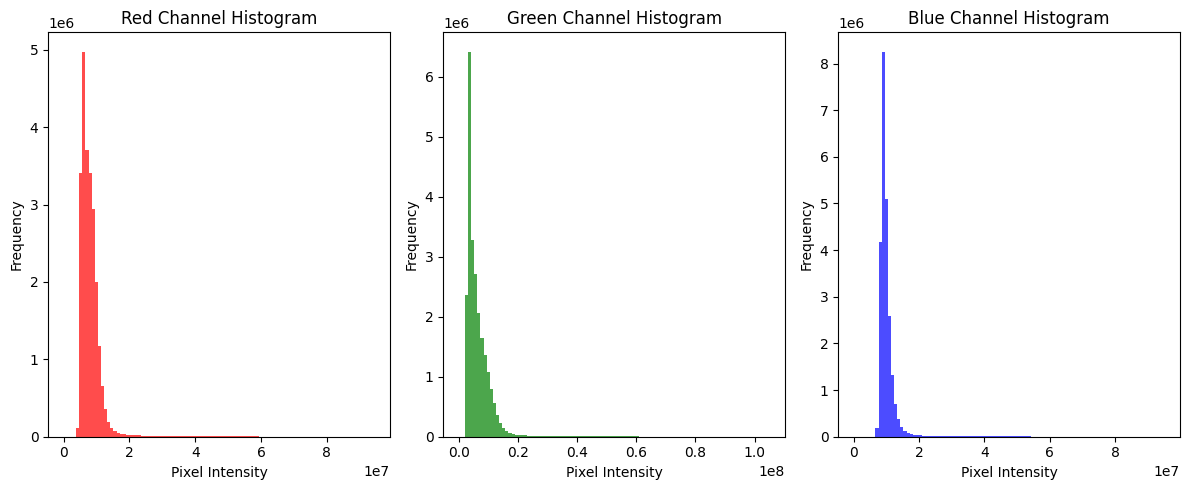

In [ ]:
blue_values = img_patches[:, blue_band, :, :].flatten()
red_values = img_patches[:, red_band, :, :].flatten()
green_values = img_patches[:, green_band, :, :].flatten()

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.hist(red_values, bins=100, color="red", alpha=0.7)
plt.title("Red Channel Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(green_values, bins=100, color="green", alpha=0.7)
plt.title("Green Channel Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(blue_values, bins=100, color="blue", alpha=0.7)
plt.title("Blue Channel Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

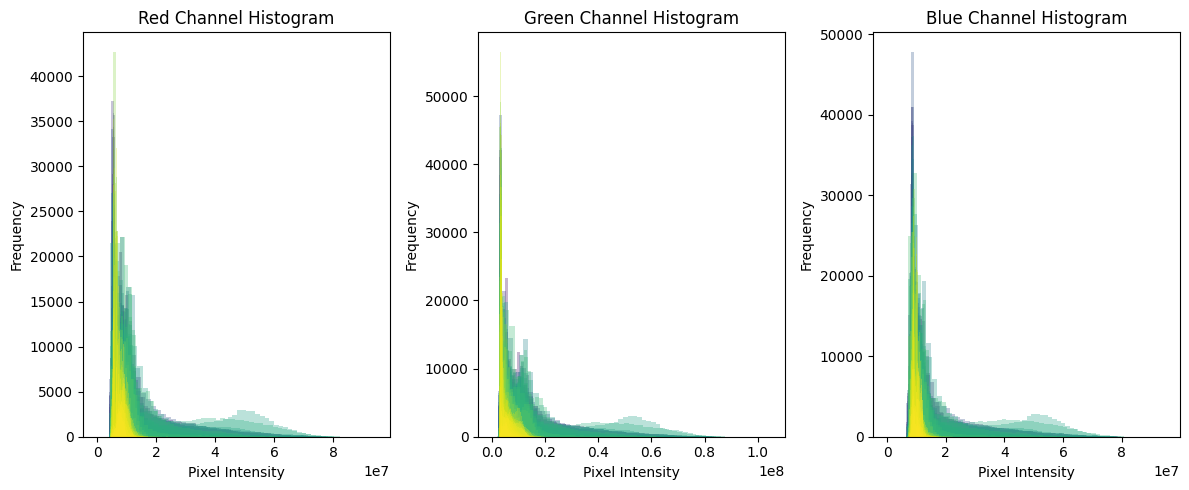

In [131]:
plt.figure(figsize=(12, 5))

colors = plt.cm.viridis(np.linspace(0, 1, len(img_patches)))

plt.subplot(1, 3, 1)
for i, color in enumerate(colors):
    plt.hist(
        img_patches[i, red_band, :, :].flatten(),
        bins=50,
        color=color,
        alpha=0.3,
        #label=f"Image {i}" if i < 5 else None,
    )
plt.title("Red Channel Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# Plot Green channel histogram
plt.subplot(1, 3, 2)
for i, color in enumerate(colors):
    plt.hist(
        img_patches[i, green_band, :, :].flatten(),
        bins=50,
        color=color,
        alpha=0.3,
        #label=f"Image {i}" if i < 5 else None,
    )
plt.title("Green Channel Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
for i, color in enumerate(colors):
    plt.hist(
        img_patches[i, blue_band, :, :].flatten(),
        bins=50,
        color=color,
        alpha=0.3,
        #label=f"Image {i}" if i < 5 else None,
    )
plt.title("Blue Channel Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

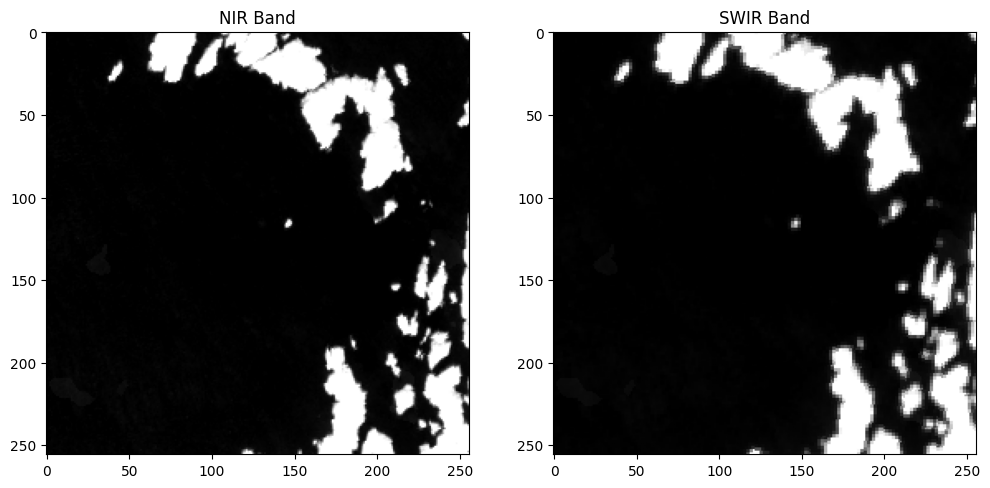

In [128]:
nir = cropped_img[nir_band].values
swir = cropped_img[swir1_band].values


def normalize(band):
    return (band - np.nanmin(band)) / (np.nanmax(band) - np.nanmin(band))


nir_norm = normalize_percentile(nir)
swir_norm = normalize_percentile(swir)

# Plot both bands
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(nir_norm, cmap="gray")
ax[0].set_title("NIR Band")

ax[1].imshow(swir_norm, cmap="gray")
ax[1].set_title("SWIR Band")

plt.show()


# RGB composite


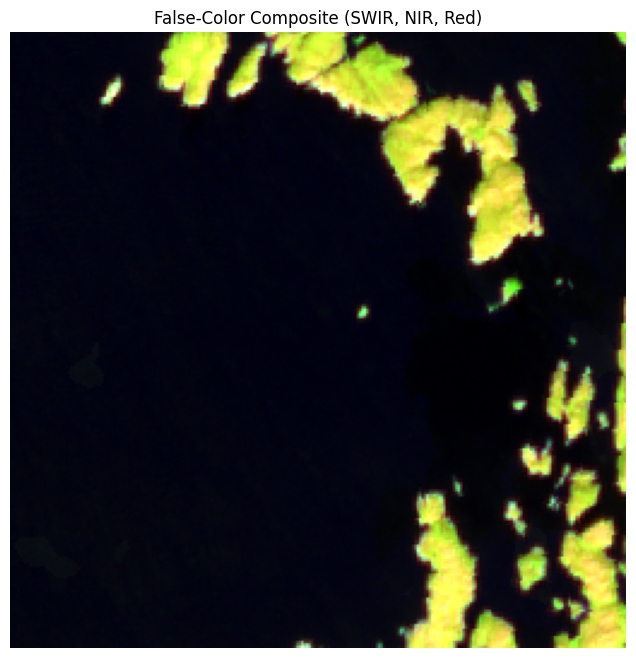

In [ ]:
# Extract Red band
red = cropped_img[red_band].values
red_norm = normalize(red)

# Create RGB composite using NIR, SWIR, and Red
rgb_composite = np.dstack((swir_norm, nir_norm, red_norm))

plt.figure(figsize=(8, 8))
plt.imshow(rgb_composite)
plt.title("False-Color Composite (SWIR, NIR, Red)")
plt.axis("off")
plt.show()

# Plot patch


In [ ]:
cropped_img_rgb = cropped_img[[red_band, green_band, blue_band]].data

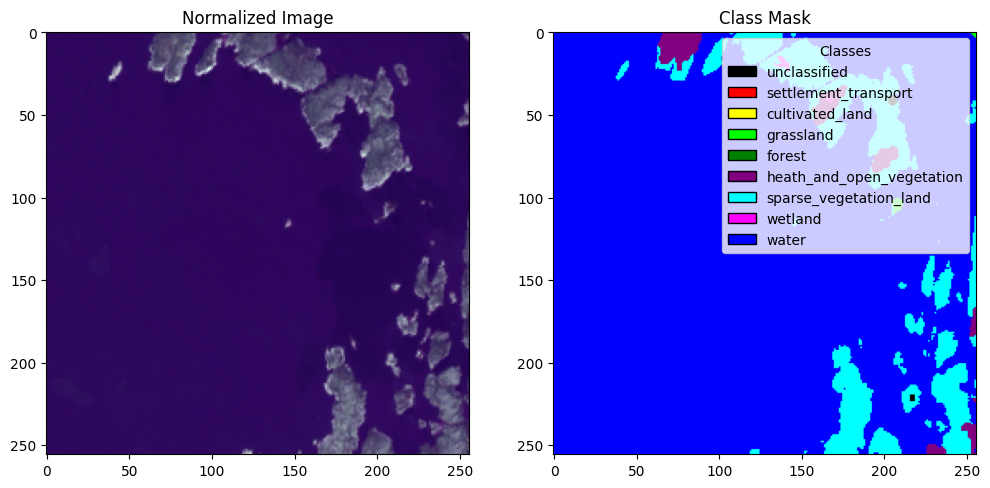

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(normalize_image(cropped_img_rgb).transpose(1, 2, 0))
axs[0].set_title("Normalized Image")

# Plot the mask
axs[1].imshow(cropped_mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")
plt.show()

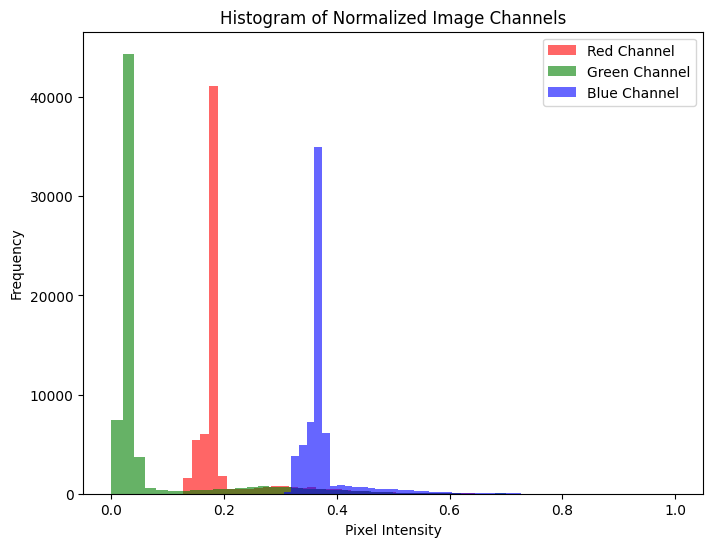

In [ ]:
import matplotlib.pyplot as plt

# Assuming norm_cropped shape is (3, H, W) for RGB channels
channels = ["Red", "Green", "Blue"]
colors = ["red", "green", "blue"]

plt.figure(figsize=(8, 6))
for i, (channel_name, color) in enumerate(zip(channels, colors, strict=False)):
    # Flatten the channel and plot the histogram
    plt.hist(
        normalize_image(cropped_img_rgb)[i].flatten(),
        bins=50,
        color=color,
        alpha=0.6,
        label=f"{channel_name} Channel",
    )

plt.title("Histogram of Normalized Image Channels")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()
